# Normalizing flows with TensorFlow Probability

In this notebook we will implement a normalizing flow, the [masked autoregressive flow](http://papers.nips.cc/paper/6828-masked-autoregressive-flow-for-density-estimation), for density estimation using Tensorflow Probability. A useful review on recent trends on normalizing flows can be found [here](https://arxiv.org/abs/1912.02762). Feedback and comments are welcome!

## Background

Normalizing flows (NFs) transform simple *base distributions* into rich, complex families of distributions that can be used for density estimation, variational inference, reparameterization of MCMC, or data generation. NFs express the distribution of a random vector $\mathbf{y} \in \mathbb{R}^p$ by applying a transformation $f$ to some random vector $\mathbf{x}$ sampled from $P_X(\mathbf{x})$:

$$\begin{align}
\mathbf{x} & \sim P_Y(\mathbf{x}) \\
\mathbf{y} &= f(\mathbf{x})
\end{align}$$

The defining property of normalizing flows is that the transformation $f$ is invertible as well as differentiable. In order for these two properties to hold, $\mathbf{x}$ must have the same dimensionality as $\mathbf{y}$. With these conditions, the density of $\mathbf{y}$ is well-defined and reads as:

$$\begin{align}
P_Y(\mathbf{y}) & = P_X\left(f^{-1}(\mathbf{y})\right)\left|\text{det} \frac{\partial f^{-1}}{\partial \mathbf{y}}\right| \\
& = P_X\left(\mathbf{x}\right)  \left| \text{det} \frac{\partial f}{\partial \mathbf{x}}  \right|^{-1}
\end{align}$$

where $\frac{\partial f^{-1}}{\partial \mathbf{y}}$ is the $p \times p$-dimensional Jacobian of $f^{-1}$ w.r.t. $\mathbf{y}$. In practice the transformation $f$ consists of a series of invertible, differentiable functions $f_1, \dots, f_K$:

$$
\mathbf{y} = \mathbf{x}_K = f_K \circ \dots f_2 \circ f_1(\mathbf{x}_0)
$$

The density of this transformation is given by:

$$\begin{align}
P_Y(\mathbf{y}) & = P_X\left(\mathbf{x}_0 \right) \prod_{k=1}^K \left| \text{det} \frac{\partial f_k}{\partial \mathbf{x}_{k - 1}}  \right|^{-1}
\end{align}$$

Computing the determinant of a Jacobian is cubic in $p$. In order to be able to use NFs in production, we would like to be able to efficiently compute the determinants of the Jacobians. Most approaches to NFs achieve that by constructing transformations which have triangular Jacobians for which the determinants can be computed in linear time.

[Masked autoregressive flows](http://papers.nips.cc/paper/6828-masked-autoregressive-flow-for-density-estimation) (MAFs) model the transformation of a sample $\mathbf{x}$ of the base distribution $P_X$ autoregressively as

$$\begin{align}
y_i &= f\left(x_i\right)\\
y_i &= x_i  \exp \left( \alpha_i \right) + \mu_i \\\\
x_i &= f^{-1}\left(y_i\right)\\
x_i &= \left(y_i - \mu_i \right)  \exp \left( -\alpha_i \right)
\end{align}$$

where $\mu_i = f_{\mu_i}\left( \mathbf{y}_{1:i-1}  \right)$ and $\alpha_i = f_{\alpha_i}\left( \mathbf{y}_{1:i-1}  \right)$ are two scalar functions. Due to the autoregressive structure the Jacobian of the inverse function $f^{-1}$ is lower triangular:

$$\begin{align}
\frac{\partial f^{-1}}{\partial \mathbf{y}} = \begin{pmatrix}
\exp(-\alpha_1)&& \mathbf{0}\\ 
&\ddots&\\
\frac{\partial f^{-1}_{2:p}}{\partial \mathbf{y}_{1:p}} && \exp(-\alpha_{2:p})
\end{pmatrix}
\end{align}$$

such that the determinant is merely the product on the diagonal.

In order to make $\mathbf{y}$ have an autoregressive structure, the authors make use of the approach used by [MADE](https://arxiv.org/abs/1502.03509), i.e., an autoencoder that enforces the autoregressive property by multiplying binary masks with the weight matrices of the autoencoder.

## Implementation

In the following we implement the *masked autoregressive flow* and *masked autoregressive distribution estimation* from scratch using TensorFlow Probability. We first load some required libraries.

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

tfk = tf.keras
tfkl = tfk.layers
tfd = tfp.distributions
tfb = tfp.bijectors

sns.set_style("white")
sns.set_context("notebook")

To implement a MAF, we first need to be able to compute the underlying autoencoder MADE. MADE uses binary masks to enforce autoregressive structure. To do that we first need to compute degree vectors which describe the maximum number of inputs an element $y_i$ can have.

In [2]:
def make_degrees(p, hidden_dims):
    m = [tf.constant(range(1, p + 1))]
    for dim in hidden_dims:                
        n_min = min(np.min(m[-1]), p - 1)
        degrees = (np.arange(dim) % max(1, p - 1) + min(1, p - 1))
        degrees = tf.constant(degrees, dtype="int32")
        m.append(degrees)
    return m

In [3]:
make_degrees(2, [4, 4])

[<tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 2], dtype=int32)>,
 <tf.Tensor: shape=(4,), dtype=int32, numpy=array([1, 1, 1, 1], dtype=int32)>,
 <tf.Tensor: shape=(4,), dtype=int32, numpy=array([1, 1, 1, 1], dtype=int32)>]

From these we can compute the binary masks. We don't do that exactly as in the original publication for reason explained later.

In [4]:
def make_masks(degrees):
    masks = [None] * len(degrees)
    for i, (ind, outd) in enumerate(zip(degrees[:-1], degrees[1:])):
        masks[i] = tf.cast(ind[:, tf.newaxis] <= outd, dtype="float32")        
    masks[-1] = tf.cast(degrees[-1][:, np.newaxis] < degrees[0], dtype="float32")
    return masks

In [5]:
make_masks(make_degrees(2, [4, 4]))

[<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
 array([[1., 1., 1., 1.],
        [0., 0., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(4, 4), dtype=float32, numpy=
 array([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]], dtype=float32)>,
 <tf.Tensor: shape=(4, 2), dtype=float32, numpy=
 array([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]], dtype=float32)>]

In order to mask a weight matrix, we can use a Dense layer and apply a constraint (hence this way of encoding the mask and not as in the paper).

In [6]:
def make_constraint(mask):    
    def _constraint(x):
        return mask * tf.identity(x)
    return _constraint

Likewise we initialize a layer using the same mask such that all elements that are being masked are initialized as zero.

In [7]:
def make_init(mask):
    def _init(shape, dtype=None):
        return mask * tf.keras.initializers.GlorotUniform(23)(shape)
    return _init

We build the autoencoder as a sequence of Keras layers. Since we are going to need two parameters for every component, i.e., to compute $y_i$ we need to compute $f_{\mu_i}\left(\mathbf{y}_{1:i-1}\right)$ and $f_{\sigma_i}\left(\mathbf{y}_{1:i-1}\right)$, we need the last layer to have $2p$ parameters.

In [8]:
def make_network(p, hidden_dims, params):
    masks = make_masks(make_degrees(p, hidden_dims))    
    masks[-1] = tf.tile(masks[-1][..., tf.newaxis], [1, 1, params])
    masks[-1] = tf.reshape(masks[-1], [masks[-1].shape[0], p * params])
    
    network =  tf.keras.Sequential([
        tf.keras.layers.InputLayer((p,))
    ])
    for dim, mask in zip(hidden_dims + [p * params], masks):
        layer = tf.keras.layers.Dense(
            dim,
            kernel_constraint=make_constraint(mask),
            kernel_initializer=make_init(mask),
            activation=tf.nn.leaky_relu)
        network.add(layer)    
    network.add(tf.keras.layers.Reshape([p, params]))
    
    return network

Let's test this:

In [9]:
network = make_network(2, [5, 5], 2)

In [10]:
X = tfd.Normal(0.0, 1.0).sample([5, 2])
network(X)

<tf.Tensor: shape=(5, 2, 2), dtype=float32, numpy=
array([[[ 0.        ,  0.        ],
        [-0.0100405 , -0.11566639]],

       [[ 0.        ,  0.        ],
        [-0.00342146, -0.03941514]],

       [[ 0.        ,  0.        ],
        [-0.00443012, -0.05103486]],

       [[ 0.        ,  0.        ],
        [ 0.01229642,  0.0715711 ]],

       [[ 0.        ,  0.        ],
        [-0.02501273, -0.2881463 ]]], dtype=float32)>

In [11]:
network.trainable_variables

[<tf.Variable 'dense/kernel:0' shape=(2, 5) dtype=float32, numpy=
 array([[ 0.00807106,  0.19659626, -0.06663984, -0.8803604 , -0.7304889 ],
        [ 0.        ,  0.        , -0.        ,  0.        , -0.        ]],
       dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(5,) dtype=float32, numpy=array([0., 0., 0., 0., 0.], dtype=float32)>,
 <tf.Variable 'dense_1/kernel:0' shape=(5, 5) dtype=float32, numpy=
 array([[ 0.00675279,  0.1644842 , -0.0557549 , -0.7365624 , -0.6111709 ],
        [ 0.40250623,  0.05572373, -0.76719   ,  0.49726534, -0.27585092],
        [-0.02227771,  0.29146564, -0.28983793, -0.23035765,  0.07482648],
        [ 0.7334652 , -0.3744525 ,  0.5454862 ,  0.0286473 , -0.18208629],
        [ 0.10813814,  0.31813288, -0.70827246, -0.39120227, -0.32971326]],
       dtype=float32)>,
 <tf.Variable 'dense_1/bias:0' shape=(5,) dtype=float32, numpy=array([0., 0., 0., 0., 0.], dtype=float32)>,
 <tf.Variable 'dense_2/kernel:0' shape=(5, 4) dtype=float32, numpy=
 array([[

In order to implement the normalizing flow, we can use TensorFlow Probability's Bijector API. To do that we create a class that inherits form `tfb.Bijector` and override functions for the forward transformation, its inverse and the determinant of the Jacobian. The inverse is easy to compute in a single pass. To sample from $P_Y$ requires performing $p$ sequential passes.

In [12]:
class MAF(tfb.Bijector):
    def __init__(self, shift_and_log_scale_fn, name="maf"):
        super(MAF, self).__init__(forward_min_event_ndims=1, name=name)
        self._shift_and_log_scale_fn = shift_and_log_scale_fn
        
    def _shift_and_log_scale(self, y):
        params = self._shift_and_log_scale_fn(y)          
        shift, log_scale = tf.unstack(params, num=2, axis=-1)
        return shift, log_scale
        
    def _forward(self, x):
        y = tf.zeros_like(x, dtype=tf.float32)
        for i in range(x.shape[-1]):            
            shift, log_scale = self._shift_and_log_scale(y)            
            y = x * tf.math.exp(log_scale) + shift
        return y

    def _inverse(self, y):
        shift, log_scale = self._shift_and_log_scale(y)
        return (y - shift) * tf.math.exp(-log_scale)

    def _inverse_log_det_jacobian(self, y):
        _, log_scale = self._shift_and_log_scale(y)
        return -tf.reduce_sum(log_scale, axis=self.forward_min_event_ndims)
    

That is all. The inverse and the determinant of its Jacobian are computed as described above. Let's test it.

In [13]:
maf = MAF(make_network(2, [5, 5], 2))
maf.forward(X)

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[-1.0171334 ,  2.3280942 ],
       [-0.34660408, -0.26917058],
       [-0.44878423, -0.49025437],
       [ 0.8056425 , -0.07196853],
       [-2.5338662 ,  0.5456896 ]], dtype=float32)>

## Density estimation

We will first test our MAF to estimate the density of the moon data set. We can sample from the moon density using `sklearn`.

In [14]:
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

n = 10000
X, _ = datasets.make_moons(n_samples=n, noise=.05)
X = StandardScaler().fit_transform(X)

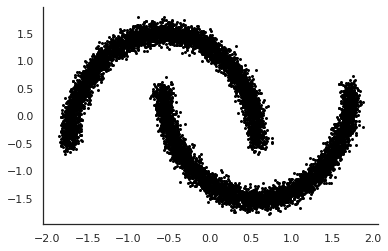

In [15]:
ax = sns.scatterplot(X[:, 0], X[:, 1], color="black", marker='.', linewidth=0);
sns.despine();

We implement the NF by stacking several layers of MAF, i.e. multiple functions $f_i$, followed by a permutation of the components.

In [16]:
hidden_dim = [512, 512]  
layers = 2
bijectors = []
for i in range(0, layers):
    made = make_network(2, hidden_dim, 2)
    bijectors.append(MAF(made))
    bijectors.append(tfb.Permute(permutation=[1, 0])) 
    
bijectors = tfb.Chain(bijectors=list(reversed(bijectors[:-1])))

To sample and be able to compute the log probabilty of a transformation using an NF we wrap the chain of bijectors as `TransformedDistribution` with a standard normal as base distribution.

In [17]:
distribution = tfd.TransformedDistribution(
    distribution=tfd.Normal(loc=0., scale=1.),
    bijector=bijectors,
    event_shape=[2]
)

To fit the density, we can again use TensorFlow's API with the negative log likelihood as loss function

In [18]:
x_ = tfkl.Input(shape=(2,), dtype=tf.float32)
log_prob_ = distribution.log_prob(x_)
model = tfk.Model(x_, log_prob_)

model.compile(optimizer=tf.optimizers.Adam(), loss=lambda _, log_prob: -log_prob)

In [19]:
_ = model.fit(x=X,
              y=np.zeros((X.shape[0], 0), dtype=np.float32),
              batch_size= X.shape[0],
              epochs=3000,
              steps_per_epoch=1,
              verbose=0,
              shuffle=False)

Having the weights optimized, we can sample from the distribution and check if the trained model is similar to the moon distribution.

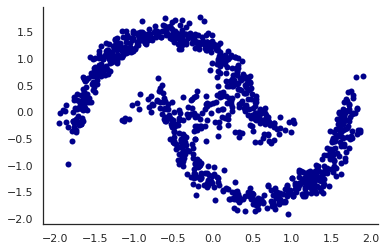

In [20]:
samples = distribution.sample(1000)
samples = StandardScaler().fit_transform(samples)
sns.scatterplot(samples[:, 0], samples[:, 1], color='darkblue', marker='o', linewidth=0);
sns.despine();